In [1]:
#loading libraries
#Some of the references are taken from books and open-souce materials 
%matplotlib inline
import matplotlib.pyplot as plt
import time
from shutil import copyfile
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import numpy as np
import torch
import copy
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as func
import torchvision
from torchvision import transforms, datasets, models
import random 
from PIL import Image
from tqdm import tqdm
import cv2
import argparse
import os
import numpy as np
import math
import statistics
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import shutil
import numpy as np 
import pandas as pd
from tqdm import tqdm
from torchvision.datasets import ImageFolder
from tqdm import tqdm 
from sklearn import metrics
import torch
import numpy as np
from torchsummary import summary
np.random.seed(0)

## Data Loader for Training

In [2]:
#for loading datasets giving path
path = 'plant-seedlings-classification/'
train_dir = path + 'train'
test_dir = path + 'test'

## Exploratory Data Analysis (EDA)

In [3]:
#preprocessing step
#transforming and loading the dataset 
transform = transforms.Compose(
    [transforms.Resize([224,224])
    ])
train_data = datasets.ImageFolder(train_dir, transform=transform)

In [5]:
#ids to different class --------> converting classes to ids
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\n All the classes:\n\n')
print(train_data.class_to_idx,'\n\n')
print('"""""""""""""""""""""""""""""""""""""""')

"""""""""""""""""""""""""""""""""""""""


 All the classes:


{'Black-grass': 0, 'Charlock': 1, 'Cleavers': 2, 'Common Chickweed': 3, 'Common wheat': 4, 'Fat Hen': 5, 'Loose Silky-bent': 6, 'Maize': 7, 'Scentless Mayweed': 8, 'Shepherds Purse': 9, 'Small-flowered Cranesbill': 10, 'Sugar beet': 11} 


"""""""""""""""""""""""""""""""""""""""


In [7]:
#giving ids to each class ---------------> storing values of ids 
idx_to_class = {value: key for key, value in train_data.class_to_idx.items()}
image_paths = [item[0] for item in train_data.imgs]

In [8]:
#classesd with their ids ---------------> displaying results
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\n All the classes with their ids::\n\n')
print(idx_to_class,'\n\n')
print('"""""""""""""""""""""""""""""""""""""""')

"""""""""""""""""""""""""""""""""""""""


 All the classes with their ids::


{0: 'Black-grass', 1: 'Charlock', 2: 'Cleavers', 3: 'Common Chickweed', 4: 'Common wheat', 5: 'Fat Hen', 6: 'Loose Silky-bent', 7: 'Maize', 8: 'Scentless Mayweed', 9: 'Shepherds Purse', 10: 'Small-flowered Cranesbill', 11: 'Sugar beet'} 


"""""""""""""""""""""""""""""""""""""""


In [9]:
#shape and length of the training data
image_shape = np.array(train_data[0][0]).shape
data_length = len(train_data)

In [10]:
#shape of the image
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nShape of an image:',image_shape,'\n\n')
print('"""""""""""""""""""""""""""""""""""""""')

"""""""""""""""""""""""""""""""""""""""


Shape of an image: (224, 224, 3) 


"""""""""""""""""""""""""""""""""""""""


In [12]:
#length of the training data
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nLength of the dataset:',data_length,'\n\n')
print('"""""""""""""""""""""""""""""""""""""""')

"""""""""""""""""""""""""""""""""""""""


Length of the training data: 4750 


"""""""""""""""""""""""""""""""""""""""


In [15]:
#Making enpty labels and data 
data_shape = list(image_shape)
data_shape.insert(0, data_length)
data = np.zeros(data_shape, dtype=np.uint8)
labels = np.zeros([data_length], dtype=np.int64)

In [16]:
#dividing labels and data
i = 0
for image, label in tqdm(train_data, desc="Reading Images"):
    data[i] = np.array(image)
    labels[i] = label
    i += 1

Reading Images: 100%|██████████| 4750/4750 [00:55<00:00, 85.13it/s] 


In [17]:
#Creatig dictionary where train_dict contains data ,labels and shape, train_infor contains ids and image paths 
train_dict = {"data": data, "labels": labels, 'data_shape': image_shape}
train_info = {"label_names": idx_to_class, "file_paths": image_paths}

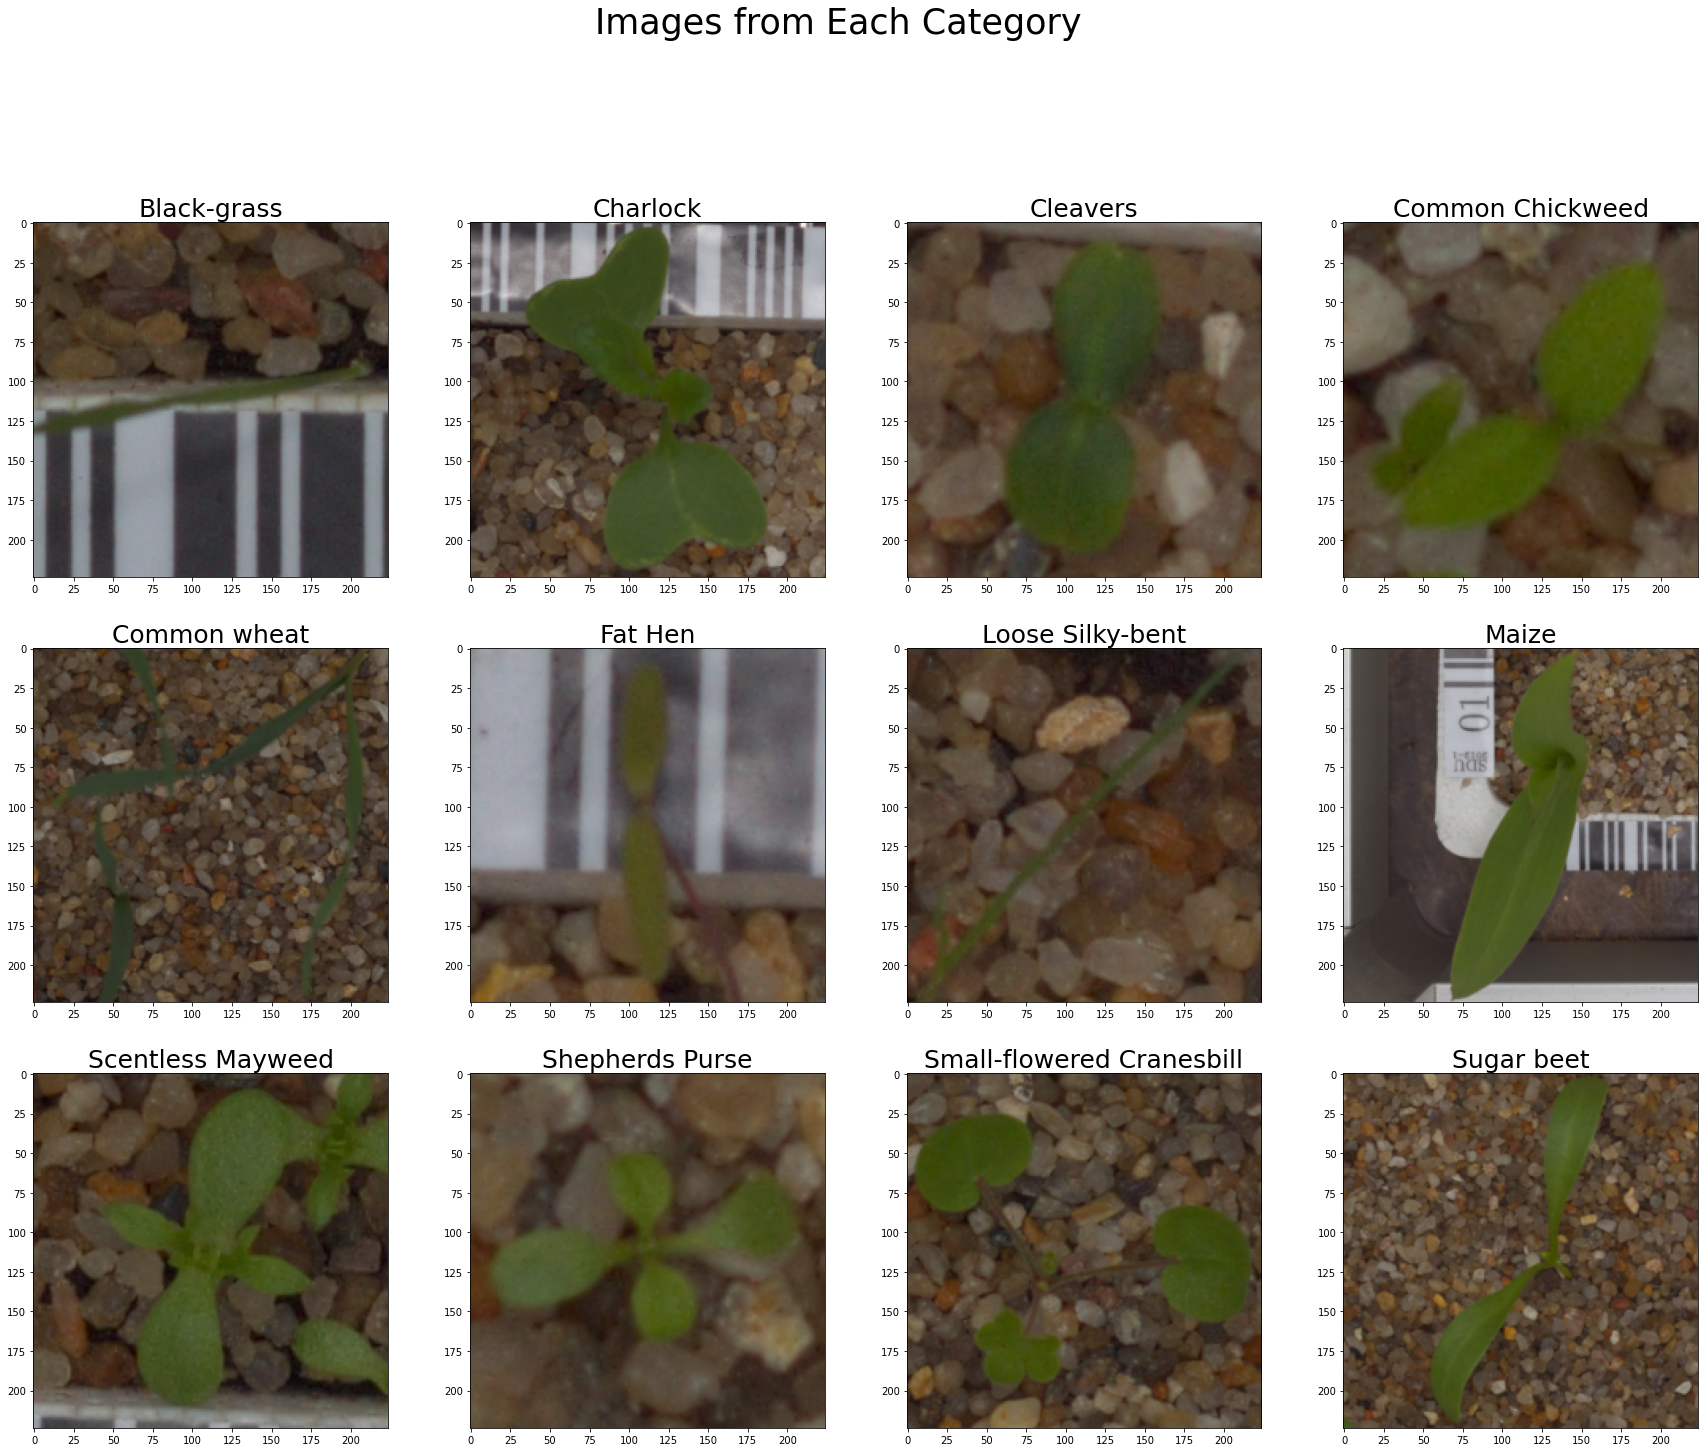

In [18]:
#Displaying images of each class 
plt.figure(figsize=(30,30))
count = 0 
i =0 
while count<12:
    if count==train_dict["labels"][i]:
        plt.suptitle('Images from Each Category',fontsize=35)
        plt.subplot(4,4,count+1)
        plt.imshow(train_dict["data"][i])
        plt.title(train_info["label_names"][train_dict["labels"][i]],fontsize=25)
        count += 1
    else:
        i += 1    

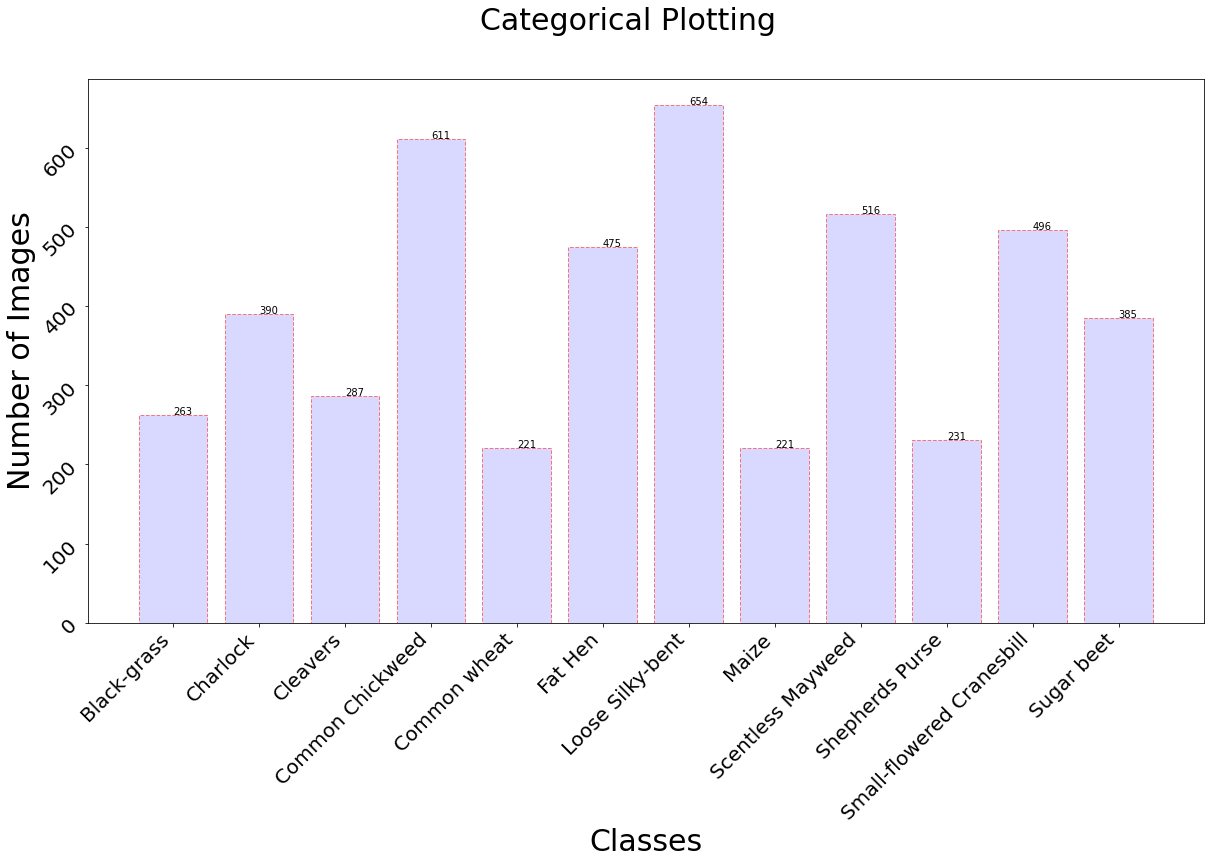

In [19]:
#Plotting the histogram for each category with it's count
labels=[]
values =[]
for label in np.unique(train_dict["labels"]):
    values.append(len(train_dict["data"][train_dict["labels"] == label]))
    labels.append(train_info["label_names"][label])
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(labels, values,color=(0,0,1,0.15),ls='dashed', lw=1, edgecolor = (1,0,0,0.5))
plt.xticks(rotation=45, ha='right',fontsize=20)
plt.yticks(rotation=45, ha='right',fontsize=20)
fig.suptitle('Categorical Plotting',fontsize=30)
ax.set_xlabel("Classes",fontsize=30)
ax.set_ylabel("Number of Images",fontsize=30)
i =0
for v in labels:
    plt.text(v, values[i], str(values[i]))
    i += 1

# Data Pre-Processing
## Digital Image Processing:
Morphological operations apply a structuring element to an input image, creating an output image of the same size.
The goal of segmentation is to simplify and/or change the representation of an image into something that is more meaningful and easier to analyze.
Sharpening an image increases the contrast between bright and dark regions to bring out features.

In [20]:
#Apply image processing on the images
def masking(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask
#segmentation
def segmentation(image):
    mask = masking(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output
#sharpening
def sharpen(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp
def segment(img):
    image_segmented = segmentation(img)
    image_sharpen = sharpen(image_segmented)
    return image_sharpen

<Figure size 2160x2160 with 0 Axes>

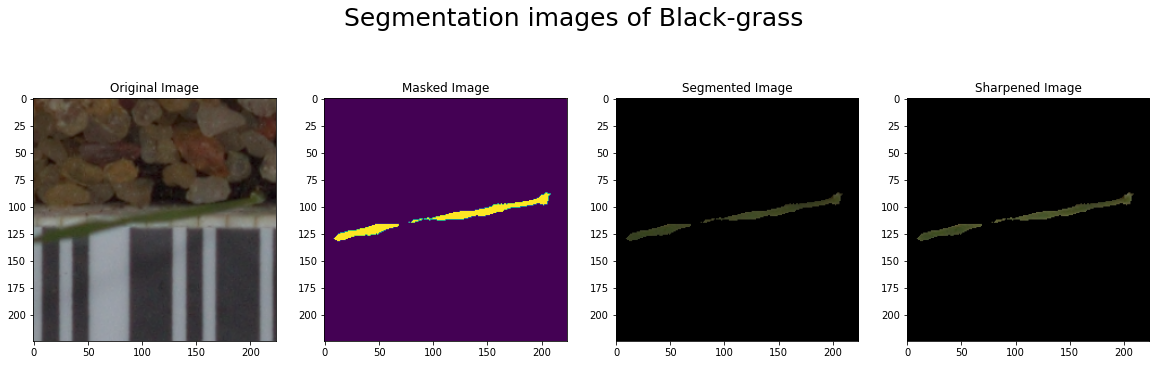

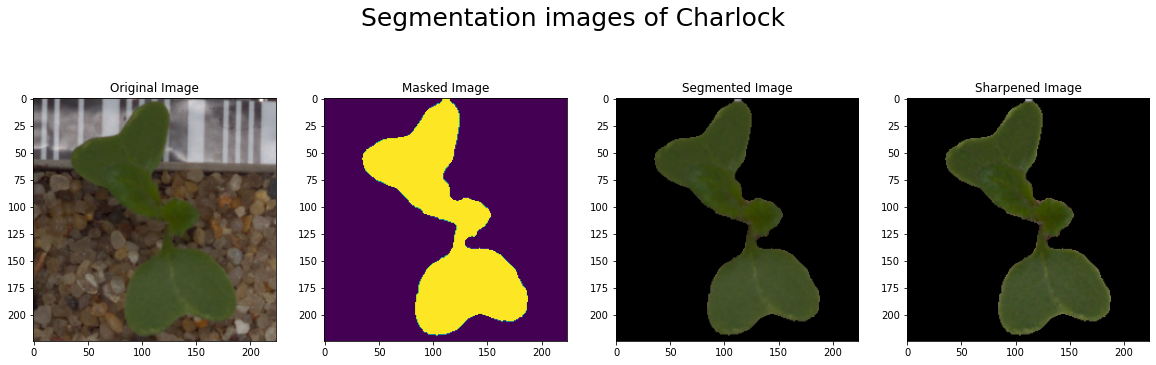

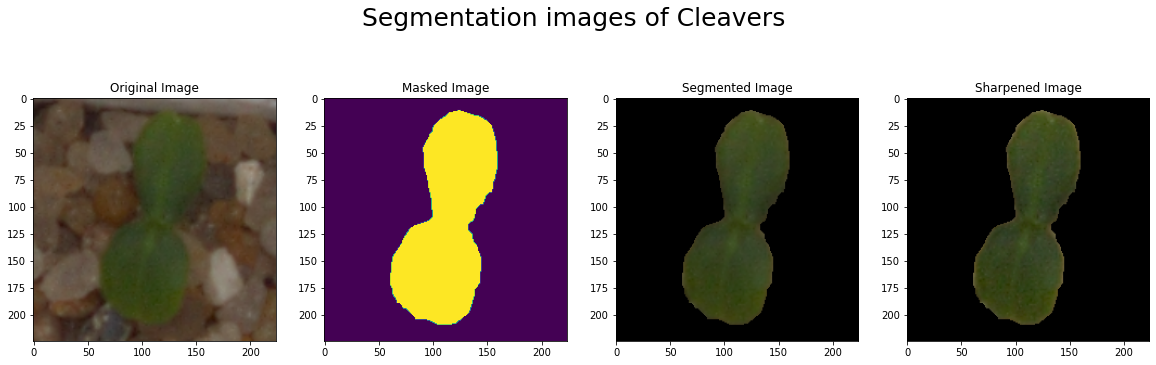

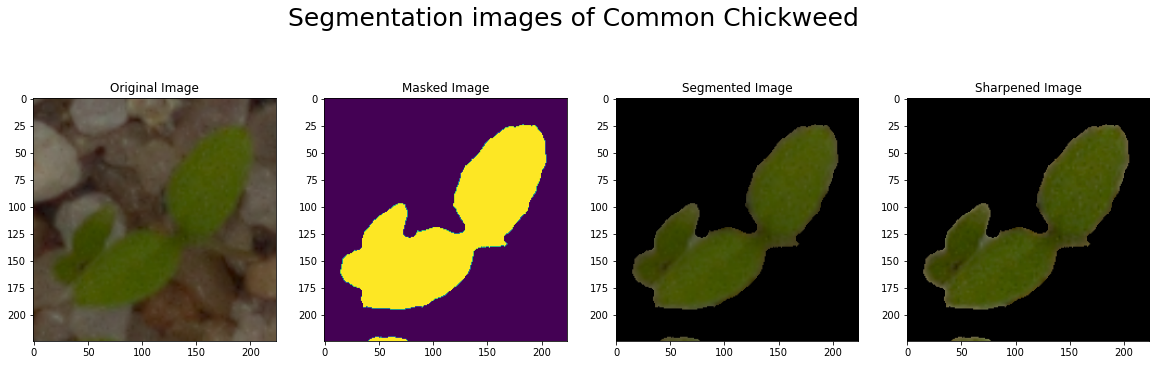

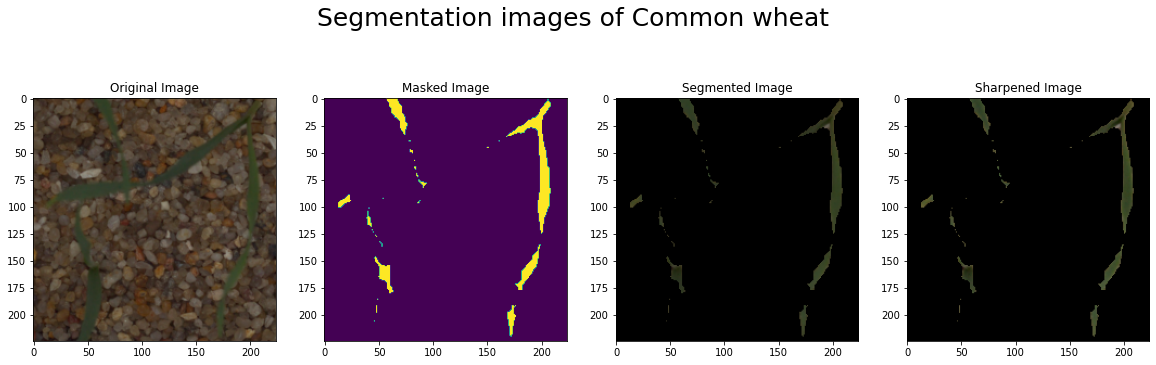

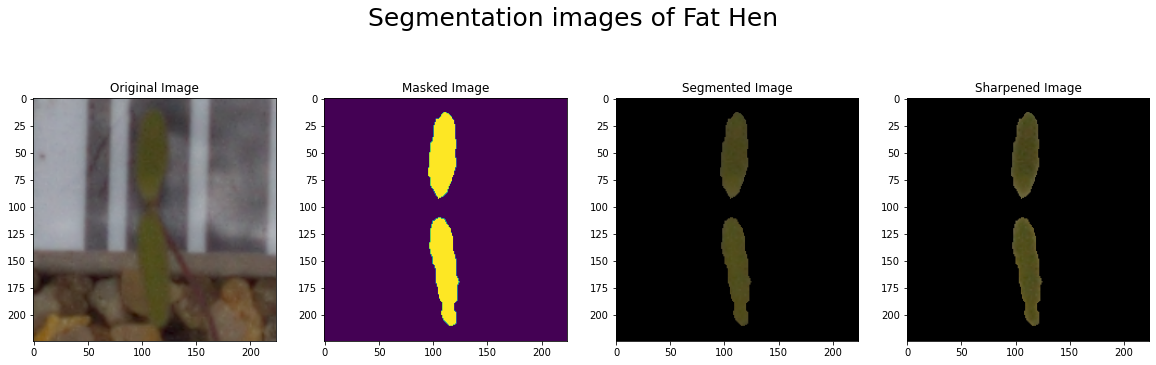

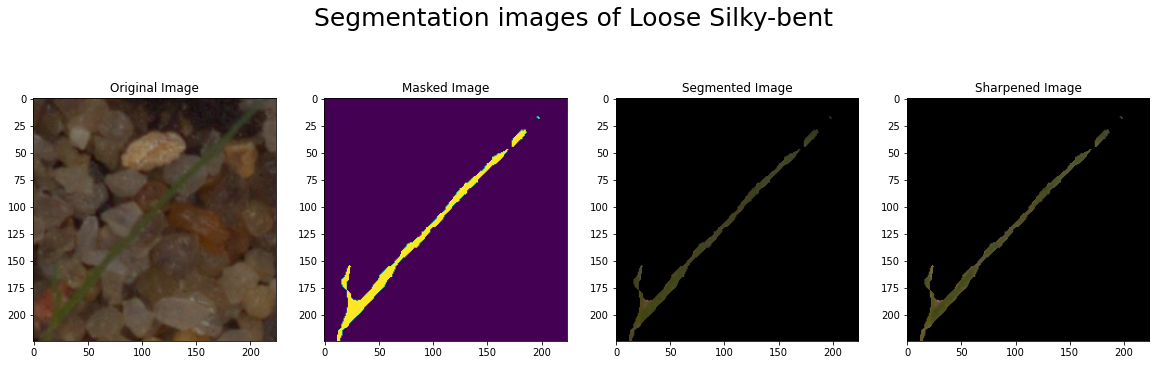

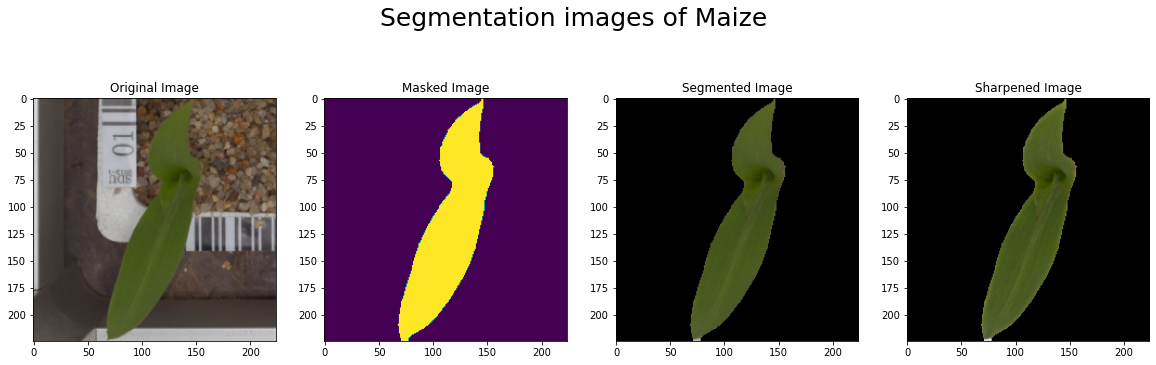

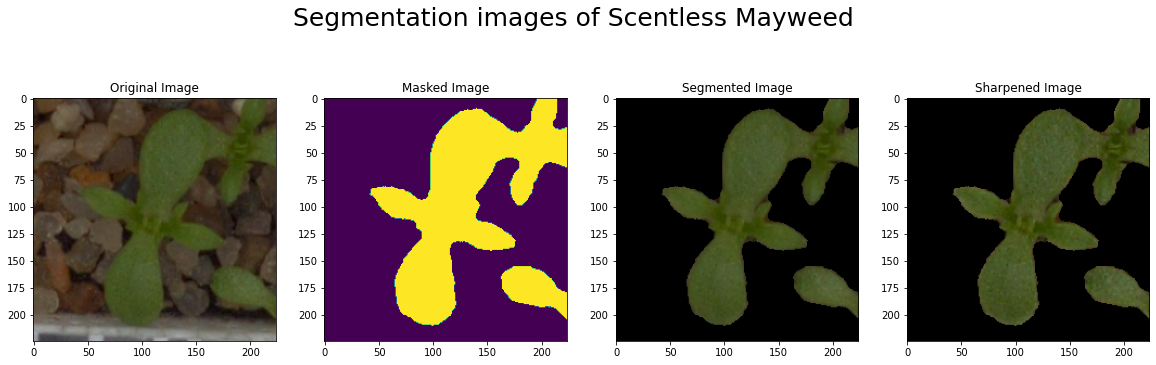

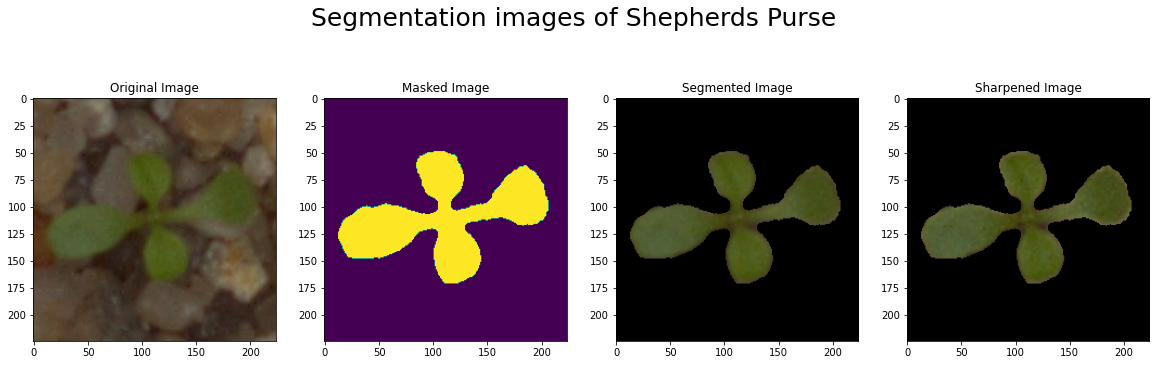

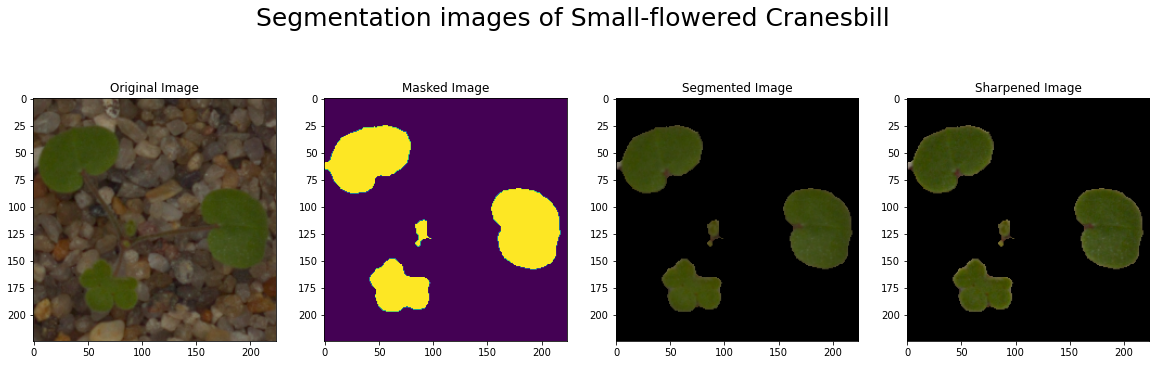

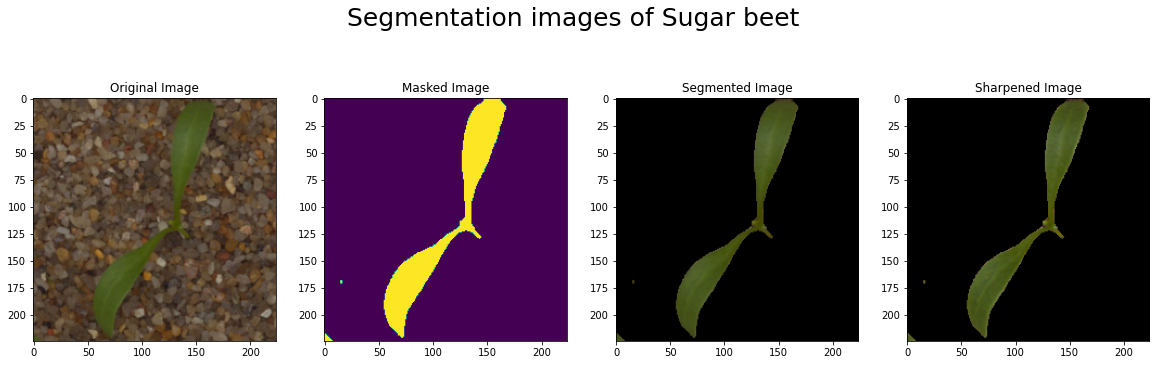

In [21]:
#plot sample image to see diffrence 
#Displaying images of each class 
plt.figure(figsize=(30,30))
count = 0 
i =0 
while count<12:
    if count==train_dict["labels"][i]:
        image = train_dict["data"][i]
        image_mask = masking(image)
        image_segmented = segmentation(image)
        image_sharpen = sharpen(image_segmented)
        fig, axs = plt.subplots(1, 4, figsize=(20, 20))
        plt.suptitle("Segmentation images of " + train_info["label_names"][train_dict["labels"][i]],fontsize=25,y=0.65)
        axs[0].set_title("Original Image")
        axs[0].imshow(image)
        axs[1].set_title("Masked Image")
        axs[1].imshow(image_mask)
        axs[2].set_title("Segmented Image")
        axs[2].imshow(image_segmented)
        axs[3].set_title("Sharpened Image")
        axs[3].imshow(image_sharpen)
        count += 1
    else:
        i += 1

In [22]:
#Removing backdround noise from all the images 
for i in range(len(train_dict["data"])):
    train_dict["data"][i]=segment(train_dict["data"][i])

## Focal Loss
Focal Loss does is that it makes it easier for the model to predict things without being 80-100% sure that this object is “something”. In simple words, giving the model a bit more freedom to take some risk when making predictions. This is particularly important when dealing with highly imbalanced datasets because in some cases , we really need to model to take a risk and predict something even if the prediction turns out to be a False Positive.

Therefore, Focal Loss is particularly useful in cases where there is a class imbalance. Another example, is in the case of Object Detection when most pixels are usually background and only very few pixels inside an image sometimes have the object of interest

In [23]:
#Focal loss will handle the class imbalance part
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=0.25, gamma=2, size_average=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = torch.Tensor([gamma])
        self.size_average = size_average
        if isinstance(alpha, (float, int, long)):
            if self.alpha > 1:
                raise ValueError('Not supported value, alpha should be small than 1.0')
            else:
                self.alpha = torch.Tensor([alpha, 1.0 - alpha])
        if isinstance(alpha, list): self.alpha = torch.Tensor(alpha)
        self.alpha /= torch.sum(self.alpha)

    def forward(self, input, target):
        if input.dim() > 2:
            input = input.view(input.size(0), input.size(1), -1)  # [N,C,H,W]->[N,C,H*W] ([N,C,D,H,W]->[N,C,D*H*W])
        # target
        # [N,1,D,H,W] ->[N*D*H*W,1]
        if self.alpha.device != input.device:
            self.alpha = torch.tensor(self.alpha, device=input.device)
        target = target.view(-1, 1)
        logpt = torch.log(input + 1e-10)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1, 1)
        pt = torch.exp(logpt)
        alpha = self.alpha.gather(0, target.view(-1))

        gamma = self.gamma

        if not self.gamma.device == input.device:
            gamma = torch.tensor(self.gamma, device=input.device)

        loss = -1 * alpha * torch.pow((1 - pt), gamma) * logpt
        if self.size_average:
            loss = loss.mean()
        else:
            loss = loss.sum()
        return loss

In [24]:
#Image Dataset class returns item and length
class ImageToTensor(torch.utils.data.Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data
        self.to_tensor = torchvision.transforms.ToTensor()
    def __getitem__(self, index):
        return self.to_tensor(self.x_data[index]), self.y_data[index]
    def __len__(self):
        return len(self.x_data)

In [26]:
#Converting images to Tensor
image_dataset = ImageToTensor(train_dict["data"], train_dict["labels"])
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nPrinting shape:\n\n')
print(image_dataset[0][0].shape,'\n\n')
print('"""""""""""""""""""""""""""""""""""""""\n\n')
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nPrinting Tensor\n\n')
print(image_dataset[4610],'\n\n')
print('"""""""""""""""""""""""""""""""""""""""')

"""""""""""""""""""""""""""""""""""""""


Printing shape:


torch.Size([3, 224, 224]) 


"""""""""""""""""""""""""""""""""""""""


"""""""""""""""""""""""""""""""""""""""


Printing Tensor


(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 11) 


""""""""""""""

In [30]:
#Dividing the dataset to training set and validation set 
def testVal_split(array, pick_num):
    index = np.arange(len(array))
    pick = np.random.choice(len(array), pick_num, replace=False)
    unpick = np.equal(np.in1d(index, pick), False)
    return array[unpick], array[pick]
#10% to validation and remaining to training data 
train_mask, valid_mask = testVal_split(np.arange(len(image_dataset)), 475)
train_set = torch.utils.data.Subset(image_dataset, train_mask)
valid_set = torch.utils.data.Subset(image_dataset, valid_mask)
#Printing the output
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nLength of Training dataset: ',len(train_set),'\n\n')
print('"""""""""""""""""""""""""""""""""""""""\n\n')
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nLength of Validation dataser: ',len(valid_set),'\n\n')
print('"""""""""""""""""""""""""""""""""""""""\n\n')
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nExample of training tensor: \n\n',train_set[4010],'\n\n')
print('"""""""""""""""""""""""""""""""""""""""\n\n')
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nExample of validation tensor: \n\n',valid_set[401],'\n\n')
print('"""""""""""""""""""""""""""""""""""""""')

"""""""""""""""""""""""""""""""""""""""


Length of Training dataset:  4275 


"""""""""""""""""""""""""""""""""""""""


"""""""""""""""""""""""""""""""""""""""


Length of Validation dataser:  475 


"""""""""""""""""""""""""""""""""""""""


"""""""""""""""""""""""""""""""""""""""


Example of training tensor: 

 (tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0., 

In [32]:
#Dataloader
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, shuffle=False)

In [33]:
#length of training data
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nLength of Training dataloader (for checking): ',len(train_loader))
print('\n\n"""""""""""""""""""""""""""""""""""""""')

"""""""""""""""""""""""""""""""""""""""


Length of Training dataloader (for checking):  4275


"""""""""""""""""""""""""""""""""""""""


In [34]:
#length of validation data 
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nLength of Validation dataloader (for checking): ',len(valid_loader))
print('\n\n"""""""""""""""""""""""""""""""""""""""')

"""""""""""""""""""""""""""""""""""""""


Length of Validation dataloader (for checking):  475


"""""""""""""""""""""""""""""""""""""""


# Modelling

## 1. CNN Model
## 2. RESNET34 - PreTrained
## 3. VGG-16 - PreTrained
## 4. Ensemble Approach

In [37]:
#Models Used
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nMODELS USED:\n\n')
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\n1. Convolutional Neural Network ----> Rank 3\n\n')
print('\n\n2. Pre-trained ResNet34  ----> Rank 1\n\n')
print('\n\n3. Pre-trained VGG-16  ----> Rank 2\n\n')
print('\n\n4. Mode Ensemble Approach ----> Rank 4\n\n')
print('"""""""""""""""""""""""""""""""""""""""')

"""""""""""""""""""""""""""""""""""""""


MODELS USED:


"""""""""""""""""""""""""""""""""""""""


1. Convolutional Neural Network ----> Rank 3




2. Pre-trained ResNet34  ----> Rank 1




3. Pre-trained VGG-16  ----> Rank 2




4. Mode Ensemble Approach ----> Rank 4


"""""""""""""""""""""""""""""""""""""""


In [39]:
#Creating Model -> CNN
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.BatchNorm2d(6),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.5),
            nn.Conv2d(6, 16, 5),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.5),
            nn.Conv2d(16, 32, 5)
        )  
        self.linear_layers = nn.Sequential(
            nn.Linear(32 * 49 * 49, 512),
            nn.ReLU(),
            nn.Linear(512, 100),
            nn.ReLU(),
            nn.Linear(100, len(np.unique(train_dict["labels"])))
        )             
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\n Convolutional Neural Network Model (CNN)\n\n')
print('"""""""""""""""""""""""""""""""""""""""')

"""""""""""""""""""""""""""""""""""""""


 Convolutional Neural Network Model (CNN)


"""""""""""""""""""""""""""""""""""""""


In [40]:
#Model Parameters
net = ConvNet()
#Loss Function
criterion = nn.CrossEntropyLoss()
#SGD optimizer
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\n Setting parameters of CNN\n\n')
print('"""""""""""""""""""""""""""""""""""""""')

"""""""""""""""""""""""""""""""""""""""


 Setting parameters of CNN


"""""""""""""""""""""""""""""""""""""""


In [43]:
#Printing summary of the model
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nSummary of our Convolutional Neural Network\n\n')
print('"""""""""""""""""""""""""""""""""""""""\n\n')
summary(net, (3, 224, 224))

"""""""""""""""""""""""""""""""""""""""


Summary of our Convolutional Neural Network


"""""""""""""""""""""""""""""""""""""""


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 220, 220]             456
       BatchNorm2d-2          [-1, 6, 220, 220]              12
         MaxPool2d-3          [-1, 6, 110, 110]               0
           Dropout-4          [-1, 6, 110, 110]               0
            Conv2d-5         [-1, 16, 106, 106]           2,416
       BatchNorm2d-6         [-1, 16, 106, 106]              32
         MaxPool2d-7           [-1, 16, 53, 53]               0
           Dropout-8           [-1, 16, 53, 53]               0
            Conv2d-9           [-1, 32, 49, 49]          12,832
           Linear-10                  [-1, 512]      39,338,496
             ReLU-11                  [-1, 512]               0
           Linear-12                 

In [45]:
#running for 15 epochs 
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nTraining Convolutional Neural Network\n\n')
print('"""""""""""""""""""""""""""""""""""""""\n\n')
for epoch in range(15):  
    running_loss = 0.0
    for i, data in enumerate(iter(train_loader), 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 50 == 49:    
            print('[%d, %5d] loss: %.4f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

"""""""""""""""""""""""""""""""""""""""


Training Convolutional Neural Network


"""""""""""""""""""""""""""""""""""""""


[1,    50] loss: 2.4680


KeyboardInterrupt: 

In [46]:
#Saving the weights
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nSaving weights of Convolutional Neural Network\n\n')
print('"""""""""""""""""""""""""""""""""""""""\n\n')
os.makedirs("CNN", exist_ok=True)
torch.save(net.state_dict(), 'CNN/simple_cnn.pth')

"""""""""""""""""""""""""""""""""""""""


Saving weights of Convolutional Neural Network


"""""""""""""""""""""""""""""""""""""""




In [47]:
#Loading the same model weights 
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nLoading weights of Convolutional Neural Network\n\n')
print('"""""""""""""""""""""""""""""""""""""""\n\n')
net = ConvNet()
net.load_state_dict(torch.load('CNN/simple_cnn.pth'))

"""""""""""""""""""""""""""""""""""""""


Loading weights of Convolutional Neural Network


"""""""""""""""""""""""""""""""""""""""




<All keys matched successfully>

In [48]:
#checking on validation set
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nChecking accuracy of Convolutional Neural Network on Vaidation set\n\n')
print('"""""""""""""""""""""""""""""""""""""""\n\n')
correct = 0
top3 = 0
total = 0
with torch.no_grad():
    for i in range(len(valid_loader)):
        try:
            images, label = valid_set.__getitem__(i)
            images = images[None, :, :]
            predictions = net(images).numpy()[0].argsort()[::-1]
            if label == predictions[0]:
                correct += 1
            if label in predictions[:3]:
                top3 += 1
            total += 1
        except:
            print('exception')
print('Accuracy of the network on the validation images: %d %%' % (100 * top3 / total))
print('\n\n"""""""""""""""""""""""""""""""""""""""')

"""""""""""""""""""""""""""""""""""""""


Checking accuracy of Convolutional Neural Network on Vaidation set


"""""""""""""""""""""""""""""""""""""""


Accuracy of the network on the validation images: 30 %


"""""""""""""""""""""""""""""""""""""""


In [50]:
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nChecking path of Test directory\n\n',test_dir)
print('\n\n"""""""""""""""""""""""""""""""""""""""\n\n')

"""""""""""""""""""""""""""""""""""""""


Checking path of Test directory

 /home/arpit/Downloads/plant-seedlings-classification/test


"""""""""""""""""""""""""""""""""""""""




In [52]:
#for Test Dataset
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nTest Dataset Loader\n\n')
print('"""""""""""""""""""""""""""""""""""""""\n\n')
class TestDataset_Loader(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.images = [os.path.join(self.data_path, dI) for dI in os.listdir(self.data_path)]
    def __len__(self):
        return len(self.images)
    def __getitem__(self, index):
        img_path = self.images[index]
        img = Image.open(img_path)
        if self.transform is not None:
            img = self.transform(img)
        return img


"""""""""""""""""""""""""""""""""""""""


Test Dataset Loader


"""""""""""""""""""""""""""""""""""""""




In [53]:
#test transform and load
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nTransforming Test Dataset\n\n')
print('"""""""""""""""""""""""""""""""""""""""\n\n')
test_transforms = transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.ToPILImage()
])
test_dataset = TestDataset_Loader(
    test_dir, 
    transform=test_transforms)

"""""""""""""""""""""""""""""""""""""""


Transforming Test Dataset


"""""""""""""""""""""""""""""""""""""""




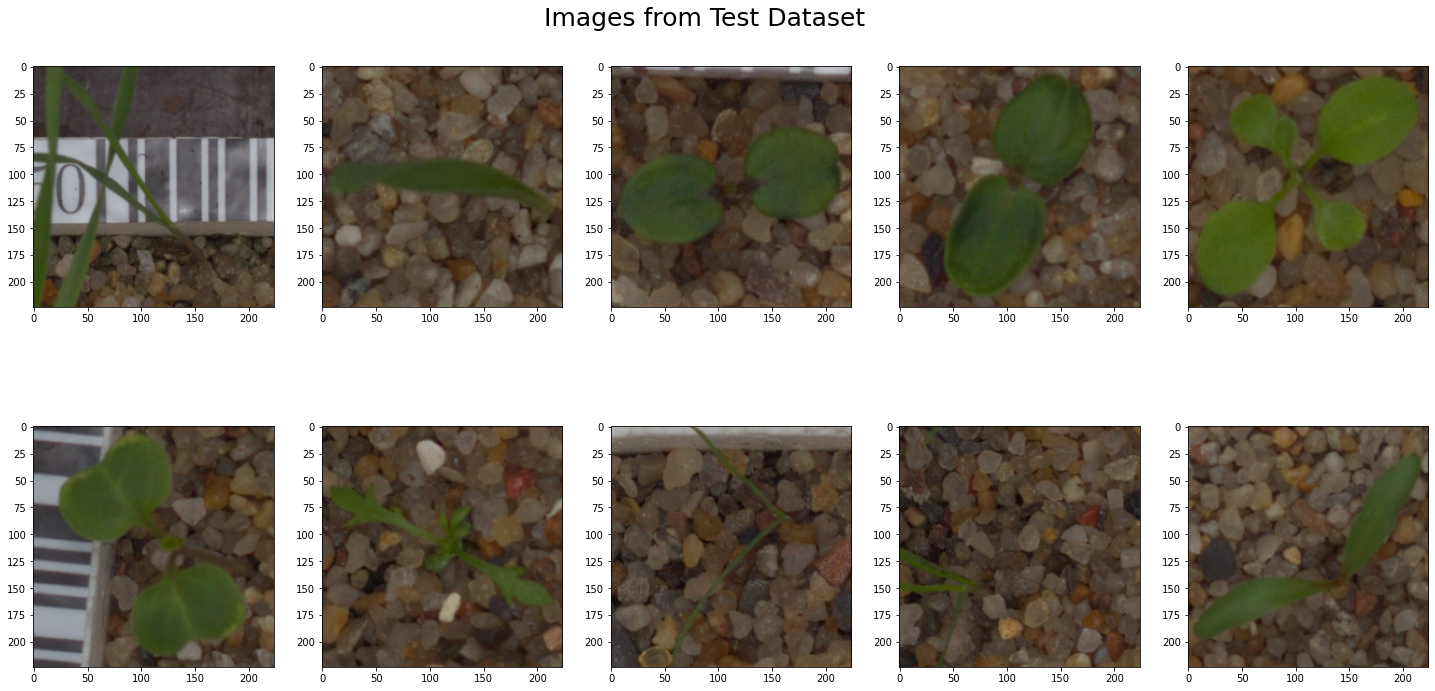

In [54]:
#Printing some test images
plt.figure(figsize=(25,25))
plt.suptitle('Images from Test Dataset ',fontsize=25,y=0.7)
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
    plt.imshow(test_dataset[i])

In [55]:
#Applying segmentation on test images 
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nSegmentation of Test Dataset\n\n')
print('"""""""""""""""""""""""""""""""""""""""\n\n')
test_da = []
for i in range(len(test_dataset)):
    test_da.append(segment(np.asarray(test_dataset[i])))

"""""""""""""""""""""""""""""""""""""""


Segmentation of Test Dataset


"""""""""""""""""""""""""""""""""""""""




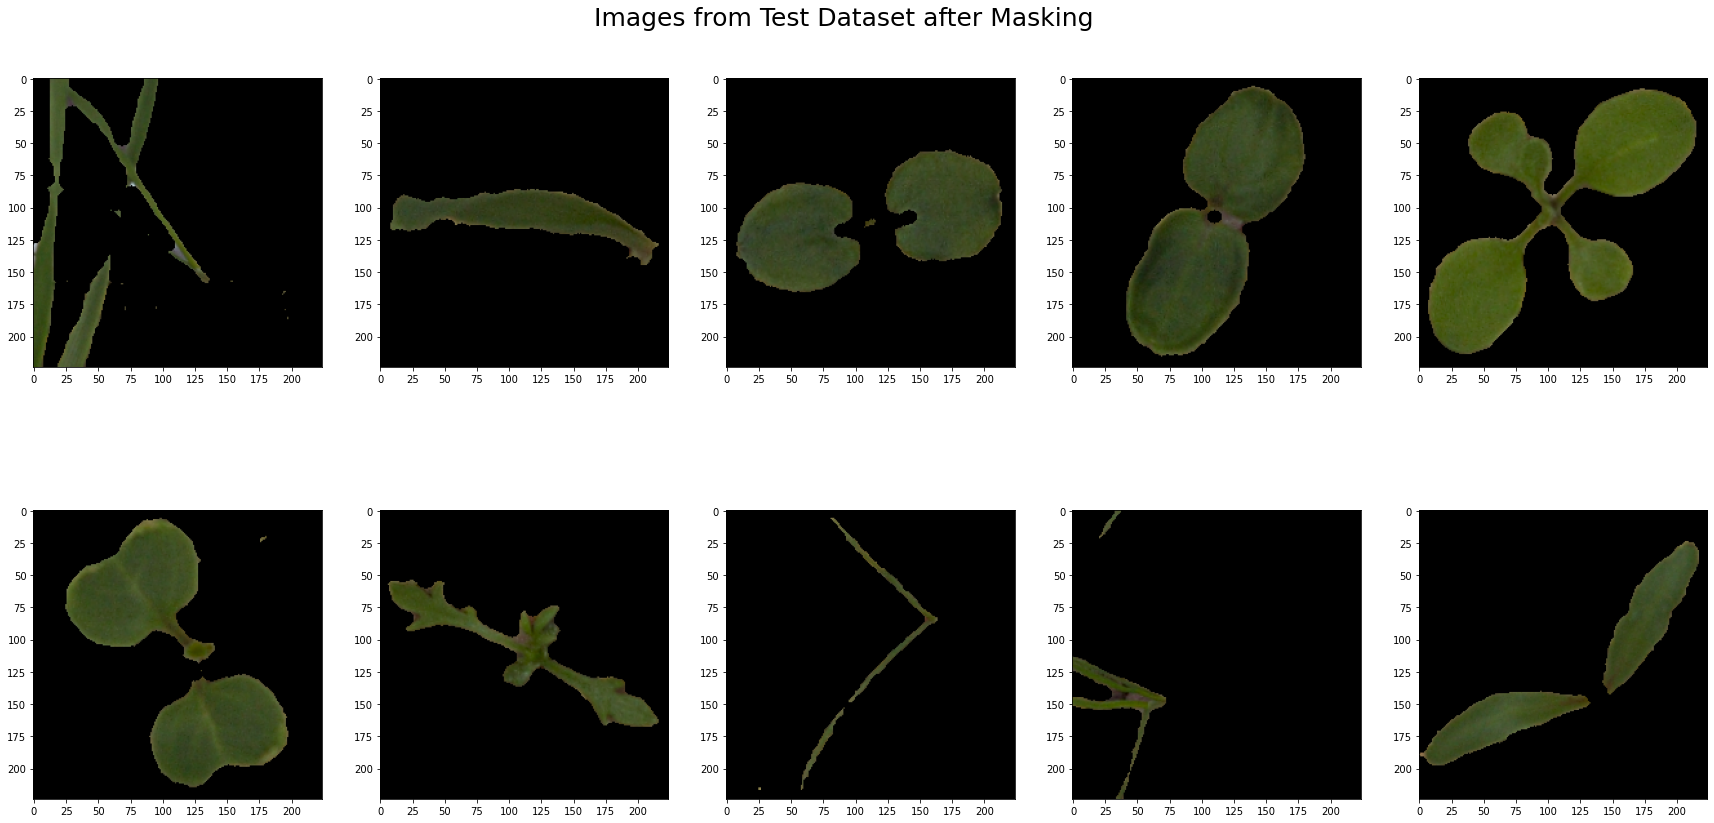

In [56]:
#Printing some images after segmentation
plt.figure(figsize=(30,30))
plt.suptitle('Images from Test Dataset after Masking',fontsize=25,y=0.7)
for i in range(10):
    plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
    plt.subplot(2,5,i+1)
    plt.imshow(test_da[i])

In [59]:
#Converting to tensors
test_dataset = ImageToTensor(test_da, train_dict["labels"])
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nShape of Test Dataset image:\n\n')
print(test_dataset[0][0].shape)
print('\n\n"""""""""""""""""""""""""""""""""""""""\n\n')
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nExample of Test Dataset tensor:\n\n')
print(test_dataset[610])
print('\n\n"""""""""""""""""""""""""""""""""""""""')

"""""""""""""""""""""""""""""""""""""""


Shape of Test Dataset image:


torch.Size([3, 224, 224])


"""""""""""""""""""""""""""""""""""""""


"""""""""""""""""""""""""""""""""""""""


Example of Test Dataset tensor:


(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0

In [61]:
#Predicting the outputs 
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nClassification of Test Dataset image:\n\n')
print('"""""""""""""""""""""""""""""""""""""""')
prediction_list = []
with torch.no_grad():
    for i in range(len(test_dataset)):
        images, label = test_dataset.__getitem__(i)
        images = images[None, :, :]
        predictions = net(images).numpy()[0].argsort()[::-1]
        prediction_list.append(predictions[0])

"""""""""""""""""""""""""""""""""""""""


Classification of Test Dataset image:


"""""""""""""""""""""""""""""""""""""""


In [63]:
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nAssigning Label Names\n\n')
print('"""""""""""""""""""""""""""""""""""""""')
for i in range(len(prediction_list)):
    prediction_list[i] = train_info["label_names"][prediction_list[i]]

"""""""""""""""""""""""""""""""""""""""


Assigning Label Names


"""""""""""""""""""""""""""""""""""""""


KeyError: 'Small-flowered Cranesbill'

In [64]:
#predictions
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nPrinting Predicted Classified Labels:\n\n')
print('"""""""""""""""""""""""""""""""""""""""')
prediction_list

"""""""""""""""""""""""""""""""""""""""


Printing Predicted Classified Labels:


"""""""""""""""""""""""""""""""""""""""


['Small-flowered Cranesbill',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Small-flowered Cranesbill',
 'Small-flowered Cranesbill',
 'Small-flowered Cranesbill',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Small-flowered Cranesbill',
 'Small-flowered Cranesbill',
 'Fat Hen',
 'Fat Hen',
 'Scentless Mayweed',
 'Small-flowered Cranesbill',
 'Small-flowered Cranesbill',
 'Small-flowered Cranesbill',
 'Small-flowered Cranesbill',
 'Small-flowered Cranesbill',
 'Scentless Mayweed',
 'Small-flowered Cranesbill',
 'Small-flowered Cranesbill',
 'Small-flowered Cranesbill',
 'Small-flowered Cranesbill',
 'Fat Hen',
 'Small-flowered Cranesbill',
 'Small-flowered Cranesbill',
 'Small-flowered Cranesbill',
 'Small-flowered Cranesbill',
 'Small-flowered Cranesbill',
 'Small-flowered Cranesbill',
 'Small-flowered Cranesbill',
 'Small-flowered Cranesbill',
 'Small-flowered Cranesbill',
 'Small-flowered Cranesbill',
 'Small-flowered Cranesbill',
 'Small-flowered Cranesbill',
 'Small-fl

In [66]:
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nSaving results in CSV\n\n')
print('"""""""""""""""""""""""""""""""""""""""')
df_test = pd.read_csv(path+'sample_submission.csv')

"""""""""""""""""""""""""""""""""""""""


Saving results in CSV


"""""""""""""""""""""""""""""""""""""""


In [48]:
df_test['species'] = prediction_list

In [49]:
#Saving results to csv
df_test.to_csv('submission_cnn.csv', index=False)

# RESNET34

In [67]:
# ResNet Baseline, Resnet18, Resnet34
class ResNet(nn.Module):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        self.model = models.resnet34(pretrained=True)
        self.model.fc = nn.Linear(in_features=512, out_features=num_classes)
        for module in ['conv1', 'bn1', 'layer1']:
            for param in getattr(self.model, module).parameters():
                param.requires_grad = False
    def forward(self, x):
        return self.model(x)
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\n ResNet34 Model(PreTrained)\n\n')
print('"""""""""""""""""""""""""""""""""""""""')

"""""""""""""""""""""""""""""""""""""""


 ResNet34 Model(PreTrained)


"""""""""""""""""""""""""""""""""""""""


In [69]:
#pretrained model with 12 classes 
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\n Passing number of classes: 12\n\n')
print('"""""""""""""""""""""""""""""""""""""""')
model = ResNet(num_classes=12)

"""""""""""""""""""""""""""""""""""""""


 Passing number of classes: 12


"""""""""""""""""""""""""""""""""""""""


In [73]:
#Summary of the model
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\n Summary of the ResNet-34 Model\n\n')
print('"""""""""""""""""""""""""""""""""""""""\n\n')
summary(model, (3, 224, 224))

"""""""""""""""""""""""""""""""""""""""


 Summary of the ResNet-34 Model


"""""""""""""""""""""""""""""""""""""""


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]  

In [74]:
#parameters
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\n Assigning parameters of ResNet34 Model\n\n')
print('"""""""""""""""""""""""""""""""""""""""')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

"""""""""""""""""""""""""""""""""""""""


 Assigning parameters of ResNet34 Model


"""""""""""""""""""""""""""""""""""""""


In [75]:
#ResNet Training
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\n Training ResNet-34 Model\n\n')
print('"""""""""""""""""""""""""""""""""""""""')
for epoch in range(15):  
    running_loss = 0.0
    for i, data in enumerate(iter(train_loader), 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 50 == 49:    
            print('[%d, %5d] loss: %.4f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

"""""""""""""""""""""""""""""""""""""""


 Training ResNet-34 Model


"""""""""""""""""""""""""""""""""""""""
[1,    50] loss: 2.4788


KeyboardInterrupt: 

In [55]:
#Saving the weights
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\n Saving weights of ResNet-34 Model\n\n')
print('"""""""""""""""""""""""""""""""""""""""')
os.makedirs("ResNet", exist_ok=True)
torch.save(net.state_dict(), 'ResNet/ResNet.pth')

In [77]:
#Predicting the outputs 
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\n Classification based on ResNet-34\n\n')
print('"""""""""""""""""""""""""""""""""""""""')
prediction_list = []
with torch.no_grad():
    for i in range(len(test_dataset)):
        images, label = test_dataset.__getitem__(i)
        images = images[None, :, :]
        predictions = model(images).numpy()[0].argsort()[::-1]
        prediction_list.append(predictions[0])

"""""""""""""""""""""""""""""""""""""""


 Classification based on ResNet-34


"""""""""""""""""""""""""""""""""""""""


In [78]:
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nAssining Label Names\n\n')
print('"""""""""""""""""""""""""""""""""""""""')
for i in range(len(prediction_list)):
    prediction_list[i] = train_info["label_names"][prediction_list[i]]

"""""""""""""""""""""""""""""""""""""""


Assining Label Names


"""""""""""""""""""""""""""""""""""""""


In [79]:
#Saving results to csv
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\n Saving the results to CSV\n\n')
print('"""""""""""""""""""""""""""""""""""""""')
df_test = pd.read_csv(path+'sample_submission.csv')
df_test['species'] = prediction_list
df_test.to_csv('submission_resnet.csv', index=False)

"""""""""""""""""""""""""""""""""""""""


 Saving the results to CSV


"""""""""""""""""""""""""""""""""""""""


# VGG-16

In [80]:
#VGG Implementation
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\n VGG-16 Model (PreTrained)\n\n')
print('"""""""""""""""""""""""""""""""""""""""')
model_conv = models.vgg16(pretrained=True)
model_conv.features.requires_grad = False
model_conv.classifier.requires_grad = True
model_conv.classifier[6].out_features = 12
criterion = nn.CrossEntropyLoss()
optimizer_ft_conv = torch.optim.SGD(params=model_conv.classifier.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft_conv, step_size=7, gamma=0.1)

"""""""""""""""""""""""""""""""""""""""


 VGG-16 Model (PreTrained)


"""""""""""""""""""""""""""""""""""""""


In [81]:
#ResNet Training
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\n Training VGG-16 Model (PreTrained)\n\n')
print('"""""""""""""""""""""""""""""""""""""""')
for epoch in range(15):  
    running_loss = 0.0
    for i, data in enumerate(iter(train_loader), 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 50 == 49:    
            print('[%d, %5d] loss: %.4f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

"""""""""""""""""""""""""""""""""""""""


 Training VGG-16 Model (PreTrained)


"""""""""""""""""""""""""""""""""""""""
[1,    50] loss: 2.5080


KeyboardInterrupt: 

In [82]:
#Saving the weights
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\n Saving Weights VGG-16 Model (PreTrained)\n\n')
print('"""""""""""""""""""""""""""""""""""""""')
os.makedirs("VGG-16", exist_ok=True)
torch.save(net.state_dict(), 'VGG-16/ResNet.pth')

"""""""""""""""""""""""""""""""""""""""


 Saving Weights VGG-16 Model (PreTrained)


"""""""""""""""""""""""""""""""""""""""


In [83]:
#Summary of the model
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\n Summary of VGG-16 Model (PreTrained)\n\n')
print('"""""""""""""""""""""""""""""""""""""""')
summary(model_conv, (3, 224, 224))

"""""""""""""""""""""""""""""""""""""""


 Summary of VGG-16 Model (PreTrained)


"""""""""""""""""""""""""""""""""""""""
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 5

In [85]:
#Predicting the outputs 
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\n Predicting classes using VGG-16 Model (PreTrained)\n\n')
print('"""""""""""""""""""""""""""""""""""""""')
prediction_list = []
with torch.no_grad():
    for i in range(len(test_dataset)):
        images, label = test_dataset.__getitem__(i)
        images = images[None, :, :]
        predictions = model(images).numpy()[0].argsort()[::-1]
        prediction_list.append(predictions[0])

"""""""""""""""""""""""""""""""""""""""


 Predicting classes using VGG-16 Model (PreTrained)


"""""""""""""""""""""""""""""""""""""""


In [86]:
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\n Assigning label names\n\n')
print('"""""""""""""""""""""""""""""""""""""""')
for i in range(len(prediction_list)):
    prediction_list[i] = train_info["label_names"][prediction_list[i]]

"""""""""""""""""""""""""""""""""""""""


 Assigning label names


"""""""""""""""""""""""""""""""""""""""


In [87]:
#Saving results to csv
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\n Saving results to CSV\n\n')
print('"""""""""""""""""""""""""""""""""""""""')
df_test = pd.read_csv(path+'sample_submission.csv')
df_test['species'] = prediction_list
df_test.to_csv('submission_vgg16.csv', index=False)

"""""""""""""""""""""""""""""""""""""""


 Saving results to CSV


"""""""""""""""""""""""""""""""""""""""


# Ensemble Approach

In [88]:
#Ensembling method
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\n Ensemble Approach\n\n')
print('"""""""""""""""""""""""""""""""""""""""')
output_1 = pd.read_csv('submission_cnn.csv')
output_2 = pd.read_csv('submission_vgg16.csv')
output_3 = pd.read_csv('submission_resnet.csv')

"""""""""""""""""""""""""""""""""""""""


 Ensemble Approach


"""""""""""""""""""""""""""""""""""""""


In [89]:
def find_max_mode(list1):
    list_table = statistics._counts(list1)
    len_table = len(list_table)

    if len_table == 1:
        max_mode = statistics.mode(list1)
    else:
        new_list = []
        for i in range(len_table):
            new_list.append(list_table[i][0])
        max_mode = max(new_list) # use the max value here
    return max_mode

In [90]:
i = 0
a=[]
while i<794:
    p = [output_1.iloc[i,1],output_2.iloc[i,1], output_3.iloc[i,1]]
    a.append(find_max_mode(p))
    i+=1

In [91]:
a = pd.DataFrame(a)

In [92]:
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\n Saving the results in CSV\n\n')
print('"""""""""""""""""""""""""""""""""""""""')
df_test = pd.read_csv(path+'sample_submission.csv')
df_test['species'] = a
df_test.to_csv('submission_ensemble.csv', index=False)

"""""""""""""""""""""""""""""""""""""""


 Saving the results in CSV


"""""""""""""""""""""""""""""""""""""""


In [93]:
print('"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""')
print('\n\nResults are in top 10% on Kaggle and can be further improved based on preprocessing and model fitting.\n\n')
print('"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""')

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


Results are in top 10% on Kaggle and can be further improved based on preprocessing and model fitting.


"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


In [97]:
print('\n\n"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""')
print('\n\nNotes:\n\n')
print('"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""')
print('\n\nBest result is for ResNet > VGG-16 > CNN > Ensemble \n\n')
print('"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""')
print('\n\nReason for bad results of Ensemble:\n\nHere we have used the mode Ensemble approach which is not good for this approach\n\n')
print('"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""')



"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


Notes:


"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


Best result is for ResNet > VGG-16 > CNN > Ensemble 


"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


Reason for bad results of Ensemble:

Here we have used the mode Ensemble approach which is not good for this approach


"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


In [100]:
print('\n\n"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""')
print('\n\nFurther Explaination:\n\n')
print('\n\n"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""')
print('\n\nConvolutional Neural Network Model\n\n')
print('Convolutional Neural Network (CNN or ConvNet) are a special kind of multi-layer neural networks, designed to recognize visual patterns directly from pixel images with minimal preprocessing')
print('\n\n"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""')
print('\n\nResNet-34 PreTrained Model\n\n')
print('At the ILSVRC 2015, the Residual Neural Network (ResNet) by Kaiming He et al introduced anovel architecture with “skip connections” and features heavy batch normalization. Such skip connections are also known as gated units or gated recurrent units and have a strong similarity to recent successful elements applied in RNNs.')
print('\n\n"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""')
print('\n\nVGG-16 PreTrained Model\n\n')
print('VGGNet consists of 16 convolutional layers and is very appealing because of its very uniform architecture. Similar to AlexNet, only 3x3 convolutions, but lots of filters. Trained on 4 GPUs for 2–3 weeks. It is currently the most preferred choice in the community for extracting features from images. The weight configuration of the VGGNet is publicly available and has been used in many other applications and challenges as a baseline feature extractor. However, VGGNet consists of 138 million parameters, which can be a bit challenging to handle.')
print('\n\n"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""')
print('\n\nEnsemble Model\n\n')
print('Ensemble methods is a machine learning technique that combines several base models in order to produce one optimal predictive model.')
print('\n\n"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""')



"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


Further Explaination:




"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


Convolutional Neural Network Model


Convolutional Neural Network (CNN or ConvNet) are a special kind of multi-layer neural networks, designed to recognize visual patterns directly from pixel images with minimal preprocessing


"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


ResNet-34 PreTrained Model


At the ILSVRC 2015, the Residual Neural Network (ResNet) by Kaiming He et al introduced anovel architecture with “skip connections” and features heavy batch normalization. Such skip connections are also known as gated units or gated recurrent units and have a strong similarity to recent successful elements applied in RNNs.


"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


VGG-16 PreTrained Model


VGGNet consists of 16 convolutional layers and is very appealing because of its very unifo